In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [4]:
models = ['resnet152', 'resnet50', 'resnext50_32x4d']
filtersName = ['None', 'Normalize', 'gradLayer']

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def createDF():
    df = pd.DataFrame()
    for model in models:
        for filterName in filtersName:
            df_ = pd.read_csv('predicteds/' + model + '_' + filterName + '.csv' )
                              
            df = pd.concat((df, df_), )
    
    df = df.reset_index(drop=True)
    return df

In [7]:
df = createDF()
df = df.sort_values(by=['filename', 'model', 'filter', 'predict']).reset_index(drop=True)
df

filename            model     filter  v  \
0        000125b9-fadb-4afd-8b90-b3ea261568b6        resnet152       None  2   
1        000125b9-fadb-4afd-8b90-b3ea261568b6        resnet152       None  0   
2        000125b9-fadb-4afd-8b90-b3ea261568b6        resnet152       None  3   
3        000125b9-fadb-4afd-8b90-b3ea261568b6        resnet152       None  1   
4        000125b9-fadb-4afd-8b90-b3ea261568b6        resnet152  Normalize  2   
...                                       ...              ...        ... ..   
4754875  fffe5c24-b891-405d-9236-2cb8b3843173  resnext50_32x4d  gradLayer  2   
4754876  fffe5c24-b891-405d-9236-2cb8b3843173  resnext50_32x4d  normalize  2   
4754877  fffe5c24-b891-405d-9236-2cb8b3843173  resnext50_32x4d  normalize  0   
4754878  fffe5c24-b891-405d-9236-2cb8b3843173  resnext50_32x4d  normalize  1   
4754879  fffe5c24-b891-405d-9236-2cb8b3843173  resnext50_32x4d  normalize  3   

          predict  sign  
0        0.997577   1.0  
1        0.999905   1.0  
2        0.999948   1.0  
3        0.999975   1.0  
4        0.999404   1.0  
...           ...   ...  
4754875  0.000004  -1.0  
4754876  0.000009  -1.0  
4754877  0.000013  -1.0  
4754878  0.000014  -1.0  
4754879  0.000016  -1.0  

[4754880 rows x 6 columns]

In [8]:
X_train, y_train = df[df['sign'] != -1].loc[:,'predict'].values.reshape(-1, 36), df[df['sign'] != -1].loc[::36,'sign'].values
X_test = df[df['sign'] == -1].loc[:,'predict'].values.reshape(-1, 36)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.ln1 = nn.Linear(36, 24)
        self.ln2 = nn.Linear(24, 24)
        self.ln3 = nn.Linear(24, 1)
        
        self.drop = nn.Dropout()

    def forward(self, x):     
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = self.drop(x)
        y = F.sigmoid(self.ln3(x))
        return y
        

In [10]:
model = Net()

weight = torch.tensor([y_train.sum() / y_train.size])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestModel': None}
    
    epochs = 3000
    
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    X_train_, X_val_  = torch.tensor(X_train_).to(device).float(), torch.tensor(X_val_).to(device).float()
    y_train_, y_val_ = torch.tensor(y_train_).to(device).float().reshape(-1, 1), torch.tensor(y_val_).to(device).float().reshape(-1, 1)
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
 
        optimizer.zero_grad()
            
        y_predict = model(X_train_)

        loss = criterion(y_predict, y_train_)
            
        loss.backward()
        optimizer.step()
            
        log['loss']['train'].append(loss.item())
        
        # Val
        model.eval()

        y_predict = model(X_val_)

        loss = criterion(y_predict, y_val_)

        log['loss']['val'].append(loss.item())

        if not log['bestModel'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            log['bestModel'] = model
            log['bestEpoch'] = epoch
            
        if not epoch % 1000:
            print(f"Epoch: {epoch} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()

Epoch: 0 / 3000 | Train loss: 0.17652627825737 | Val loss: 0.17630809545516968
Epoch: 1000 / 3000 | Train loss: 0.03910224139690399 | Val loss: 0.03369124233722687
Epoch: 2000 / 3000 | Train loss: 0.008393904194235802 | Val loss: 0.004414358176290989
Wall time: 13.1 s


2999


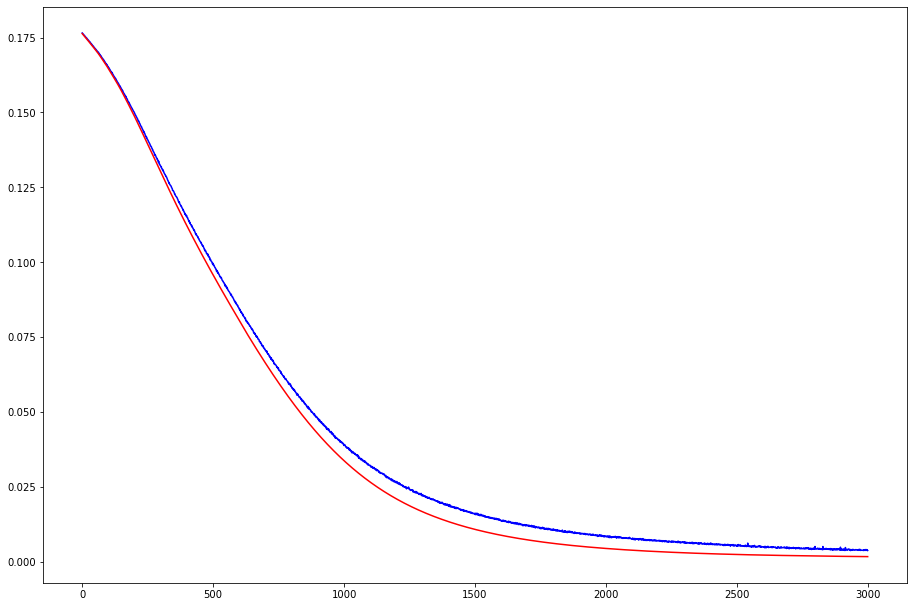

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [13]:
model = log['bestModel']

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)    

    X_test = torch.tensor(X_test).to(device).float()
    predict = model(X_test).reshape(-1).cpu()
        
predict

Wall time: 40 ms


tensor([0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039])

In [15]:
predict_df = pd.DataFrame({
    'sign': predict,
    'filename': df[df['sign'] == -1]['filename'].unique()
})

In [16]:
predict_df.to_csv('../../predict/19.csv', index=False)